Epoch 1/1300
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 215.5959
Epoch 2/1300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 116.5622 
Epoch 3/1300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 80.9219 
Epoch 4/1300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 71.1197
Epoch 5/1300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 61.1540 
Epoch 6/1300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 57.4418 
Epoch 7/1300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 53.4275
Epoch 8/1300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 49.2916 
Epoch 9/1300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 50.5739 
Epoch 10/1300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 46.7015 
Epoch 11/1300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 44.7089 
Epoch 12/1300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 43.1597
Epoch 13/1300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 40.1843 
Epoch 14/1300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 37.4412
Epoch 15/1300
19/19 ━━━━━━━━━━━━

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Synthetic data generation and export complete.


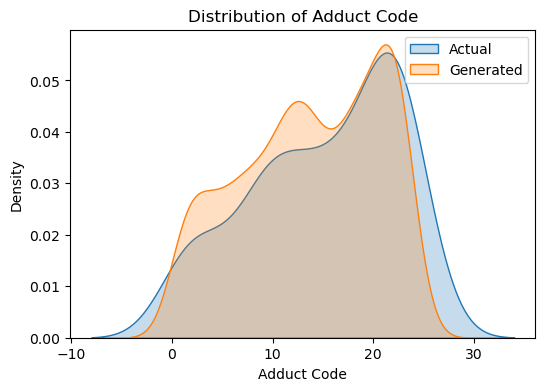

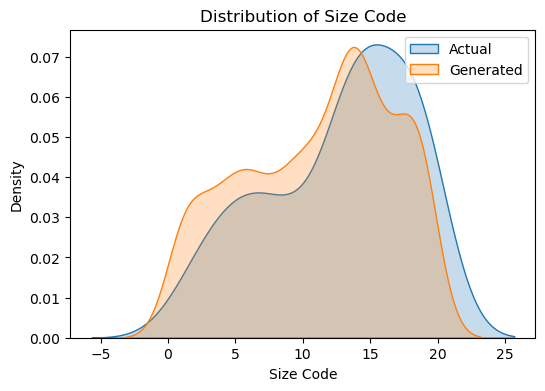

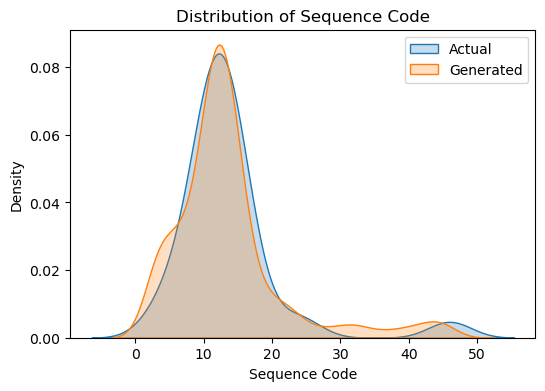

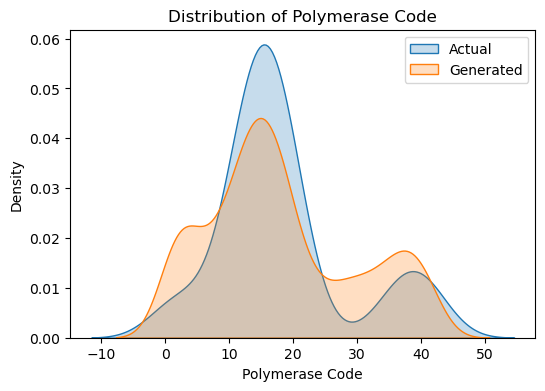

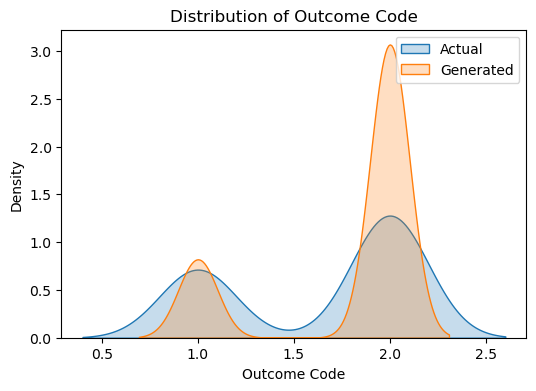

In [6]:
# 
# This notebook implements a Bootstrapped Variational Autoencoder (BT-VAE) to generate synthetic genetic data for toxicological classification.
# The original dataset, containing features like Adduct, Size, Sequence, and Polymerase, was bootstrapped to 600 samples to increase diversity.
# A VAE model was trained on the bootstrapped data to learn its latent structure, and 1,000 synthetic samples were generated.
# The similarity between real and synthetic data was assessed using KDE plots and KL Divergence, Maximum Mean Discrepancy (MMD) and Wasserstein Distance confirming good alignment.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Lambda, Dropout, LayerNormalization
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Load your dataset
file_path = 'Genedata1.csv'
df = pd.read_csv(file_path)

# Bootstrap the data to increase the number of samples to 500
bootstrap_samples = 600
bootstrapped_df = df.sample(n=bootstrap_samples, replace=True)

# Convert to numpy arrays and ensure float32 type
data_array = bootstrapped_df.to_numpy().astype('float32')

# Determine input shape for VAE
num_features = data_array.shape[1]

# VAE architecture
latent_dim = 4  # Latent dimension size

# Encoder
encoder_inputs = Input(shape=(num_features,), dtype='float32', name='encoder_input')
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01), name='encoder_dense1')(encoder_inputs)
x = LayerNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01), name='encoder_dense2')(x)
x = LayerNormalization()(x)
x = Dropout(0.3)(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# Reparameterization trick
def sampling(z_mean, z_log_var):
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.random.normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Lambda(lambda x: sampling(*x), output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# Decoder
decoder_inputs = Input(shape=(latent_dim,), name='z_sampling')
x_decoded = Dense(128, activation='relu', kernel_regularizer=l2(0.01), name='decoder_dense1')(decoder_inputs)
x_decoded = LayerNormalization()(x_decoded)
x_decoded = Dropout(0.3)(x_decoded)
x_decoded = Dense(256, activation='relu', kernel_regularizer=l2(0.01), name='decoder_dense2')(x_decoded)
x_decoded = LayerNormalization()(x_decoded)
x_decoded = Dropout(0.3)(x_decoded)
outputs = Dense(num_features, activation='linear', name='decoder_output')(x_decoded)  # Use linear activation for numeric data

# Define the VAE model
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
decoder = Model(decoder_inputs, outputs, name='decoder')
vae_outputs = decoder(encoder(encoder_inputs)[2])
vae = Model(encoder_inputs, vae_outputs, name='vae')

# VAE loss function (using Mean Squared Error)
mse_loss = MeanSquaredError()

def vae_loss(inputs, outputs, z_mean, z_log_var):
    reconstruction_loss = mse_loss(inputs, outputs)
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1) * -0.5
    return K.mean(reconstruction_loss + kl_loss)

# Custom loss function wrapper
def loss_fn(inputs, outputs):
    z_mean, z_log_var = encoder(inputs)[:2]
    return vae_loss(inputs, outputs, z_mean, z_log_var)

# Compile the VAE model with a lower learning rate
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss=loss_fn)

# Early stopping callback
early_stopping = EarlyStopping(monitor='loss', patience=20, restore_best_weights=True)

# Train the VAE model
vae.fit(data_array, data_array, epochs=1300, batch_size=32, callbacks=[early_stopping])

# Save the trained VAE model
vae.save('vae_model_enhanced.h5')

# Load the trained VAE model
vae = load_model('vae_model_enhanced.h5', custom_objects={'loss_fn': loss_fn, 'sampling': sampling})

# Generate synthetic data
num_samples = 1000
z_sample = np.random.normal(size=(num_samples, latent_dim)).astype('float32')
generated_data = decoder.predict(z_sample)

# Convert the generated data back to integers
generated_data = np.rint(generated_data).astype(int)

# Clip the generated data to be within the valid range of original data
for i in range(num_features):
    generated_data[:, i] = np.clip(generated_data[:, i], df.iloc[:, i].min(), df.iloc[:, i].max())

# Create a DataFrame for the generated data
generated_df = pd.DataFrame(generated_data, columns=df.columns)

# Export the generated data to a CSV file
generated_df.to_csv('BootVAE_Genedata6.csv', index=False)

print("Synthetic data generation and export complete.")

# Ensure generated data has similar scale to original data
for col in df.columns:
    generated_df[col] = np.round(generated_df[col]).astype(int)
    generated_df[col] = np.clip(generated_df[col], df[col].min(), df[col].max())

# Combine actual and generated data for visualization
combined_df = pd.concat([df, generated_df], ignore_index=True)
combined_df['Type'] = ['Actual'] * len(df) + ['Generated'] * len(generated_df)

# Visualize actual and generated data using KDE plots
def plot_distribution(df, column, title):
    plt.figure(figsize=(6, 4))
    sns.kdeplot(data=df[df['Type'] == 'Actual'][column], label='Actual', fill=True)
    sns.kdeplot(data=df[df['Type'] == 'Generated'][column], label='Generated', fill=True)
    plt.title(f'Distribution of {title}')
    plt.legend()
    plt.show()

for column in df.columns:
    plot_distribution(combined_df, column, column)


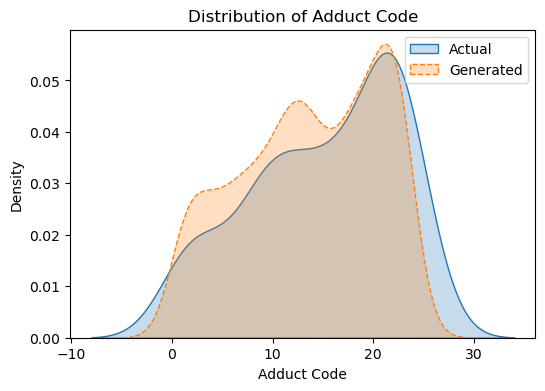

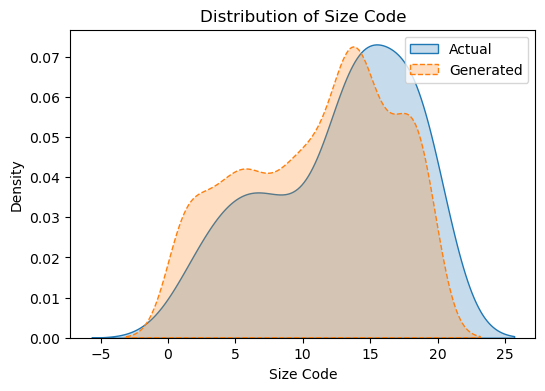

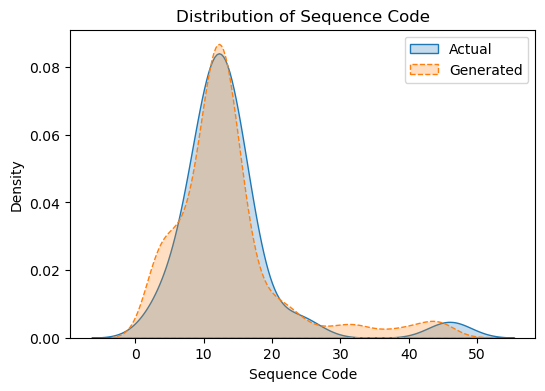

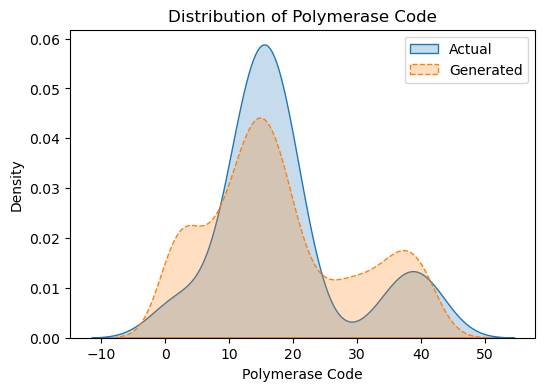

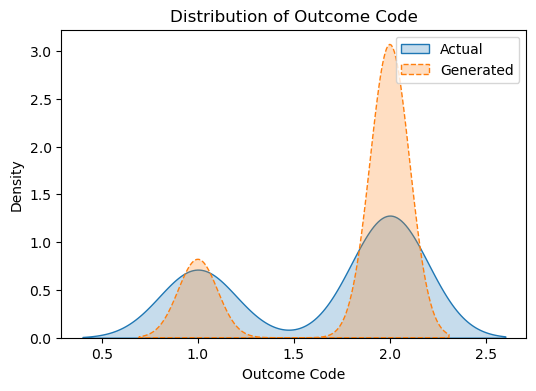

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the actual and generated data CSV files
file_path_actual = 'Genedata1.csv'
file_path_generated = 'BootVAE_Genedata6.csv'

df_actual = pd.read_csv(file_path_actual)
df_generated = pd.read_csv(file_path_generated)

# Ensure that the generated data columns match the actual data columns
assert df_actual.columns.tolist() == df_generated.columns.tolist(), "Column names do not match between the datasets."

# Combine actual and generated data for visualization
combined_df = pd.concat([df_actual, df_generated], ignore_index=True)
combined_df['Type'] = ['Actual'] * len(df_actual) + ['Generated'] * len(df_generated)

# Plot actual and generated data using KDE plots
def plot_distribution(df, column, title):
    plt.figure(figsize=(6, 4))
    sns.kdeplot(data=df[df['Type'] == 'Actual'][column], label='Actual',linestyle='-', fill=True)
    sns.kdeplot(data=df[df['Type'] == 'Generated'][column], label='Generated',linestyle='--', fill=True)
    plt.title(f'Distribution of {title}')
    plt.legend()
    plt.show()

    # Save the plot as an image file
    #plt.savefig(f'E:/DELL-KAVI/Desktop/New folder/Genetics Classification/{title}.png', dpi=300)
    #plt.close()
    
# Plotting each column
for column in df_actual.columns:
    plot_distribution(combined_df, column, column)


In [63]:
import numpy as np
from scipy.stats import gaussian_kde

def kl_divergence(p, q):
    """Compute the KL divergence between two probability distributions."""
    # Normalize distributions
    p = p / np.sum(p)
    q = q / np.sum(q)
    
    # Handle zero values to avoid log(0)
    p = np.clip(p, 1e-10, 1)
    q = np.clip(q, 1e-10, 1)
    
    # Calculate KL divergence
    return np.sum(p * np.log(p / q))

def calculate_kl_divergence(df1, df2, column):
    kde1 = gaussian_kde(df1[column].dropna(), bw_method='scott')
    kde2 = gaussian_kde(df2[column].dropna(), bw_method='scott')
    
    # Define the range for evaluation
    x = np.linspace(min(df1[column].min(), df2[column].min()), 
                    max(df1[column].max(), df2[column].max()), 1000)
    
    # Evaluate the KDEs
    p = kde1.evaluate(x)
    q = kde2.evaluate(x)
    
    # Compute KL divergence
    return kl_divergence(p, q)

# Load your datasets
import pandas as pd
file_path_actual = 'Genedata1.csv'
file_path_generated = 'BootVAE_Genedata6.csv'

df_actual = pd.read_csv(file_path_actual)
df_generated = pd.read_csv(file_path_generated)

# Compute KL Divergence for each column
for column in df_actual.columns:
    kl_div = calculate_kl_divergence(df_actual, df_generated, column)
    print(f'KL Divergence for {column}: {kl_div}')


KL Divergence for Adduct Code: 0.01527688997889512
KL Divergence for Size Code: 0.01970642869877437
KL Divergence for Sequence Code: 0.043424791700723595
KL Divergence for Polymerase Code: 0.0819534054545804
KL Divergence for Outcome Code: 0.7506182248952616


In [65]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist

def compute_mmd(X, Y, kernel='rbf', gamma=1.0):
    """Compute the Maximum Mean Discrepancy (MMD) between two datasets."""
    
    # Define the RBF kernel function
    def rbf_kernel(X, Y, gamma):
        sq_dists = cdist(X, Y, 'sqeuclidean')
        return np.exp(-gamma * sq_dists)
    
    # Compute kernel matrices
    XX = rbf_kernel(X, X, gamma)
    XY = rbf_kernel(X, Y, gamma)
    YY = rbf_kernel(Y, Y, gamma)
    
    # Compute MMD^2
    mmd_squared = np.mean(XX) + np.mean(YY) - 2 * np.mean(XY)
    
    return np.sqrt(mmd_squared)

def calculate_mmd(df1, df2, column):
    """Calculate MMD for a specific column."""
    X = df1[column].dropna().values.reshape(-1, 1)
    Y = df2[column].dropna().values.reshape(-1, 1)
    
    return compute_mmd(X, Y)

# Load your datasets
file_path_actual = 'Genedata1.csv'
file_path_generated = 'BootVAE_Genedata6.csv'

df_actual = pd.read_csv(file_path_actual)
df_generated = pd.read_csv(file_path_generated)

# Compute MMD for each column
for column in df_actual.columns:
    mmd_value = calculate_mmd(df_actual, df_generated, column)
    print(f'MMD for {column}: {mmd_value}')


MMD for Adduct Code: 0.1445593566908402
MMD for Size Code: 0.15924835006292082
MMD for Sequence Code: 0.17052740333325625
MMD for Polymerase Code: 0.2577873724950146
MMD for Outcome Code: 0.1653123242116361


In [67]:
import numpy as np
import pandas as pd
from scipy.stats import wasserstein_distance

def calculate_wasserstein_distance(df1, df2, column):
    """Calculate Wasserstein distance for a specific column."""
    # Extract the data for the specified column and drop NaN values
    data1 = df1[column].dropna().values
    data2 = df2[column].dropna().values
    
    # Compute Wasserstein distance
    return wasserstein_distance(data1, data2)

# Load your datasets
file_path_actual = 'Genedata1.csv'
file_path_generated = 'BootVAE_Genedata6.csv'

df_actual = pd.read_csv(file_path_actual)
df_generated = pd.read_csv(file_path_generated)

# Compute Wasserstein distance for each column
for column in df_actual.columns:
    wd_value = calculate_wasserstein_distance(df_actual, df_generated, column)
    print(f'Wasserstein Distance for {column}: {wd_value}')


Wasserstein Distance for Adduct Code: 1.4448641975308645
Wasserstein Distance for Size Code: 1.5689753086419755
Wasserstein Distance for Sequence Code: 1.468246913580246
Wasserstein Distance for Polymerase Code: 2.7343456790123453
Wasserstein Distance for Outcome Code: 0.14702469135802468


In [69]:
import pandas as pd

# Load your datasets
file_path_actual = 'Genedata1.csv'
file_path_generated = 'BootVAE_Genedata6.csv'

df_actual = pd.read_csv(file_path_actual)
df_generated = pd.read_csv(file_path_generated)

# Initialize dictionaries to store statistics
stats_actual = {}
stats_generated = {}

# Compute statistics for actual data
for column in df_actual.columns:
    if df_actual[column].dtype in [np.float64, np.int64]:  # Process only numerical columns
        mean_actual = df_actual[column].mean()
        sd_actual = df_actual[column].std()
        median_actual = df_actual[column].median()
        
        stats_actual[column] = {
            'Mean': mean_actual,
            'Standard Deviation': sd_actual,
            'Median': median_actual
        }

# Compute statistics for generated data
for column in df_generated.columns:
    if df_generated[column].dtype in [np.float64, np.int64]:  # Process only numerical columns
        mean_generated = df_generated[column].mean()
        sd_generated = df_generated[column].std()
        median_generated = df_generated[column].median()
        
        stats_generated[column] = {
            'Mean': mean_generated,
            'Standard Deviation': sd_generated,
            'Median': median_generated
        }

# Convert to DataFrames for better readability
stats_actual_df = pd.DataFrame(stats_actual).T
stats_generated_df = pd.DataFrame(stats_generated).T

# Print or save the statistics
print("Actual Data Statistics:")
print(stats_actual_df)
print("\nGenerated Data Statistics:")
print(stats_generated_df)


Actual Data Statistics:
                      Mean  Standard Deviation  Median
Adduct Code      15.111111            7.231874    16.0
Size Code        12.641975            5.360291    14.0
Sequence Code    13.530864            7.569819    12.0
Polymerase Code  18.086420           10.092321    16.0
Outcome Code      1.641975            0.482407     2.0

Generated Data Statistics:
                   Mean  Standard Deviation  Median
Adduct Code      13.726            6.844982    14.0
Size Code        11.073            5.520883    12.0
Sequence Code    13.554            8.388173    12.0
Polymerase Code  18.032           11.545921    16.0
Outcome Code      1.789            0.408223     2.0
